In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision


from tinyimagenet import TinyImageNet

from old.vae2 import Encoder, Decoder

In [2]:
if(torch.cuda.is_available()):
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

# set seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

Using CUDA


In [3]:
# # CIFAR100

# data = torch.utils.data.DataLoader(
#         torchvision.datasets.CIFAR100('./data',
#                transform=torchvision.transforms.ToTensor(),
#                download=True),
#         batch_size=32, shuffle=True)

# TinyImageNet

dataset = TinyImageNet('./data/tiny-imagenet-200', 'train')
data = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
def reparameterize(mean, variance):
    # Reparameterization trick
    epsilon = torch.randn_like(variance).to(device)
    return mean + epsilon * variance

def train_vae(encoder: Encoder, decoder: Decoder, data, device, epochs=1):
    # Initialize the optimizer
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

    # Training loop
    for epoch in range(epochs):
        total_reconstruction_loss = 0
        total_kl_loss = 0
        for batch in data:
            # Send the data to the device
            batch = batch[0].to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            mean, log_variance = encoder(batch) # p(z|x)
            z = reparameterize(mean, torch.exp(0.5 * log_variance)) # sample z ~ p(z|x)
            decoded = decoder(z) # d(z)
            # Loss computation
            reconstruction_loss = F.mse_loss(decoded, batch, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
            loss = reconstruction_loss + kld_loss
            total_reconstruction_loss += reconstruction_loss.item()
            total_kl_loss += kld_loss.item()
            # Backward pass
            loss.backward()
            # Update the parameters
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Reconstruction Loss: {total_reconstruction_loss / len(data.dataset)}, KL Loss: {total_kl_loss / len(data.dataset)}')

In [7]:

# Load model

encoder = Encoder(ch=32).to(device)
decoder = Decoder(ch=32).to(device)

# encoder.load_state_dict(torch.load('encoder.pth'))
# decoder.load_state_dict(torch.load('decoder.pth'))

# Train the VAE
train_vae(encoder, decoder, data, device, epochs=1)

# Save the model
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')


Epoch 1/1, Reconstruction Loss: 417.95397775390626, KL Loss: 91.43612598999023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


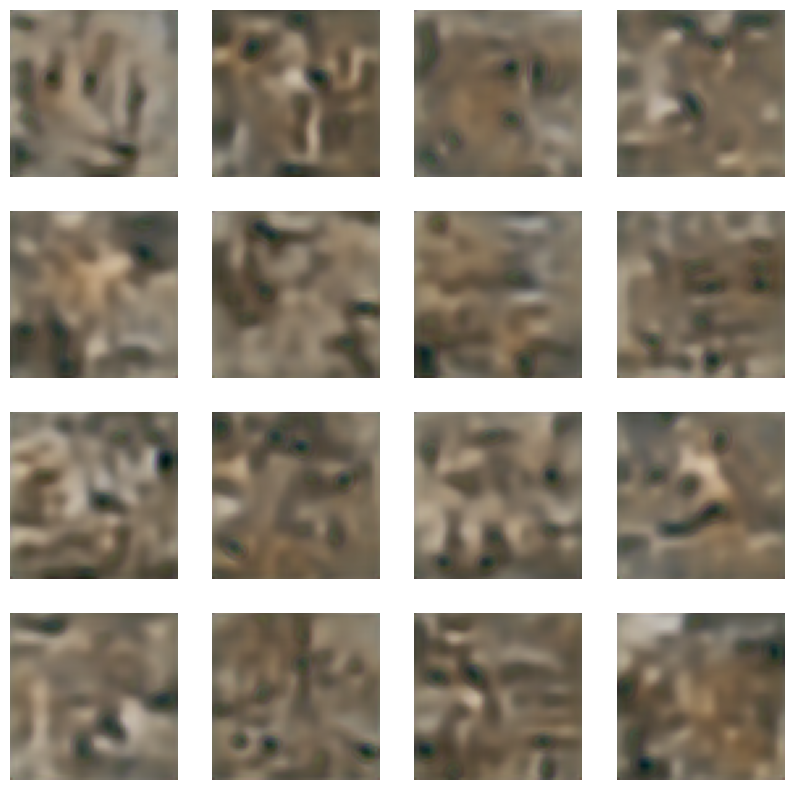

In [8]:
# Generate samples

def generate_samples(decoder, device, num_samples):
    with torch.no_grad():
        # Generate random noise (num_samples, 3, 16, 16)
        noise = torch.randn(num_samples, 3, 16, 16).to(device)
        # Decode the noise
        samples = decoder(noise)
    return samples

def tranfrom(images, encoder, decoder):
    with torch.no_grad():
        # Encode the images
        mean, log_variance = encoder(images)
        z = reparameterize(mean, torch.exp(0.5 * log_variance))
        # Decode the images
        decoded = decoder(z)
    return decoded

samples = generate_samples(decoder, device, 16)

# Visualize the samples (ad big as possible)

def visualize_samples(rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(rows):
        for j in range(cols):
            ax[i, j].imshow(samples[i * cols + j].permute(1, 2, 0).cpu().numpy())
            ax[i, j].axis('off')
    plt.show()

visualize_samples(4, 4)

